data cleaning + visualization for hoi dataset

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

hoi_df = pd.read_csv('Health_Opportunity_Index_20231106.csv')
hoi_df['Rural_Urban_Binary'] = hoi_df['Rural~Urban'].map({'Urban': 1, 'Rural': 0})
hoi_df['VA FIPS'] = hoi_df['Census Tract'].astype(str).str.slice(0, 5)


numeric_columns = hoi_df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('Rural_Urban_Binary')
hoi_by_county_df = hoi_df.groupby('VA FIPS')[numeric_columns].mean().reset_index()

rural_urban_mode = hoi_df.groupby('VA FIPS')['Rural_Urban_Binary'].agg(lambda x: x.mode()[0]).reset_index()

scaler = StandardScaler()
hoi_columns = [col for col in hoi_by_county_df.columns if col not in ["VA FIPS", "Rural_Urban_Binary"]]
hoi_by_county_df[hoi_columns] = scaler.fit_transform(hoi_by_county_df[hoi_columns])


hoi_by_county_df = pd.merge(hoi_by_county_df, rural_urban_mode, on='VA FIPS', how='left')

hoi_by_county_df.head()


,VA FIPS,Census Tract,Access to Care,Employment Accessibility,Affordability,Air Quality,Population Churning,Education,Food Accessibility,Income Inequality,...,Population Density,Segregation,Material Deprivation,Walkability,Community Environment Profile,Consumer Opportunity Profile,Economic Opportunity Profile,Wellness Disparity Profile,Health Opportunity Index,Rural_Urban_Binary
0,51001,-0.979648,0.369232,-1.640850,-0.960820,0.491330,1.043762,-0.570371,0.358433,-1.123238,...,-0.541821,0.289547,-0.852740,-0.418753,-0.343736,-0.011710,-1.280296,0.169702,-0.608202,0
1,51003,-0.972552,2.659885,0.708806,0.770750,0.191248,-0.457596,2.252551,0.366421,-0.938467,...,0.160637,0.644738,0.883900,0.184481,0.433547,1.719478,-0.020605,2.013176,1.007630,1
2,51005,-0.964912,-0.961977,-1.390333,0.870049,0.666784,0.686278,-0.325457,0.691240,0.329659,...,-0.454198,0.379010,0.792254,-0.328925,-0.682066,0.948004,-0.841555,-1.063963,-0.179539,1
3,51007,-0.954376,-0.983891,-0.173371,-0.054471,0.538690,1.071464,-0.790464,0.806923,0.432397,...,-0.593554,0.609750,0.406815,-0.876051,-0.873106,0.031987,-0.078968,-1.210059,0.109795,1
4,51009,-0.950385,-0.155823,0.587137,-0.398990,-0.534418,0.229859,-0.674603,-1.164792,0.705501,...,-0.475401,-0.282041,0.580899,-0.855238,-0.604957,-1.101534,0.793965,0.016082,0.579308,1


combine tables

In [ ]:
overdose_df = pd.read_csv('VDH-PUD-Overdose_Deaths_By-FIPS_20231106.csv')
overdose_2021_df = overdose_df[overdose_df['Death Year'] == 2021].copy()
overdose_2021_df['VA FIPS'] = overdose_2021_df['VA FIPS'].astype(str)
hoi_by_county_df['VA FIPS'] = hoi_by_county_df['VA FIPS'].astype(str)
combined_df = pd.merge(overdose_2021_df, hoi_by_county_df, on='VA FIPS', how='left')

combined_df['Walkability_RuralUrban_Interaction'] = combined_df['Walkability'] * combined_df['Rural_Urban_Binary']
combined_df['PopChurn_EmpAccess_Interaction'] = combined_df['Population Churning'] * combined_df['Employment Accessibility']
combined_df['EmployAccJobPart'] = combined_df['Job Participation'] * combined_df['Employment Accessibility']
combined_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Death Year                          133 non-null    int64  
 1   VA FIPS                             133 non-null    object 
 2   Locality Name                       133 non-null    object 
 3   Drug Class Legend                   133 non-null    object 
 4   Death Count                         133 non-null    int64  
 5   Death Rate                          133 non-null    float64
 6   Census Tract                        133 non-null    float64
 7   Access to Care                      133 non-null    float64
 8   Employment Accessibility            133 non-null    float64
 9   Affordability                       133 non-null    float64
 10  Air Quality                         133 non-null    float64
 11  Population Churning                 133 non-n

In [ ]:
correlation_matrix = combined_df.corr(numeric_only=True)
correlation_with_overdose = correlation_matrix[['Death Count', 'Death Rate']]
print(correlation_with_overdose)

                                    Death Count  Death Rate
Death Year                                  NaN         NaN
Death Count                            1.000000    0.237256
Death Rate                             0.237256    1.000000
Census Tract                           0.198379    0.228372
Access to Care                         0.250133   -0.075983
Employment Accessibility               0.451802   -0.097788
Affordability                          0.077036   -0.363995
Air Quality                           -0.403315   -0.240916
Population Churning                   -0.224862    0.072094
Education                              0.284194   -0.317704
Food Accessibility                     0.018997   -0.163365
Income Inequality                      0.231341   -0.106633
Job Participation                      0.380292   -0.081260
Population Density                     0.365400   -0.069993
Segregation                            0.014635   -0.071642
Material Deprivation                  -0

In [ ]:
correlation_matrix = combined_df.corr(numeric_only=True)
correlation_with_overdose = correlation_matrix[['Death Count', 'Death Rate']]
print(correlation_with_overdose)

                                    Death Count  Death Rate
Death Year                                  NaN         NaN
Death Count                            1.000000    0.237256
Death Rate                             0.237256    1.000000
Census Tract                           0.198379    0.228372
Access to Care                         0.250133   -0.075983
Employment Accessibility               0.451802   -0.097788
Affordability                          0.077036   -0.363995
Air Quality                           -0.403315   -0.240916
Population Churning                   -0.224862    0.072094
Education                              0.284194   -0.317704
Food Accessibility                     0.018997   -0.163365
Income Inequality                      0.231341   -0.106633
Job Participation                      0.380292   -0.081260
Population Density                     0.365400   -0.069993
Segregation                            0.014635   -0.071642
Material Deprivation                  -0

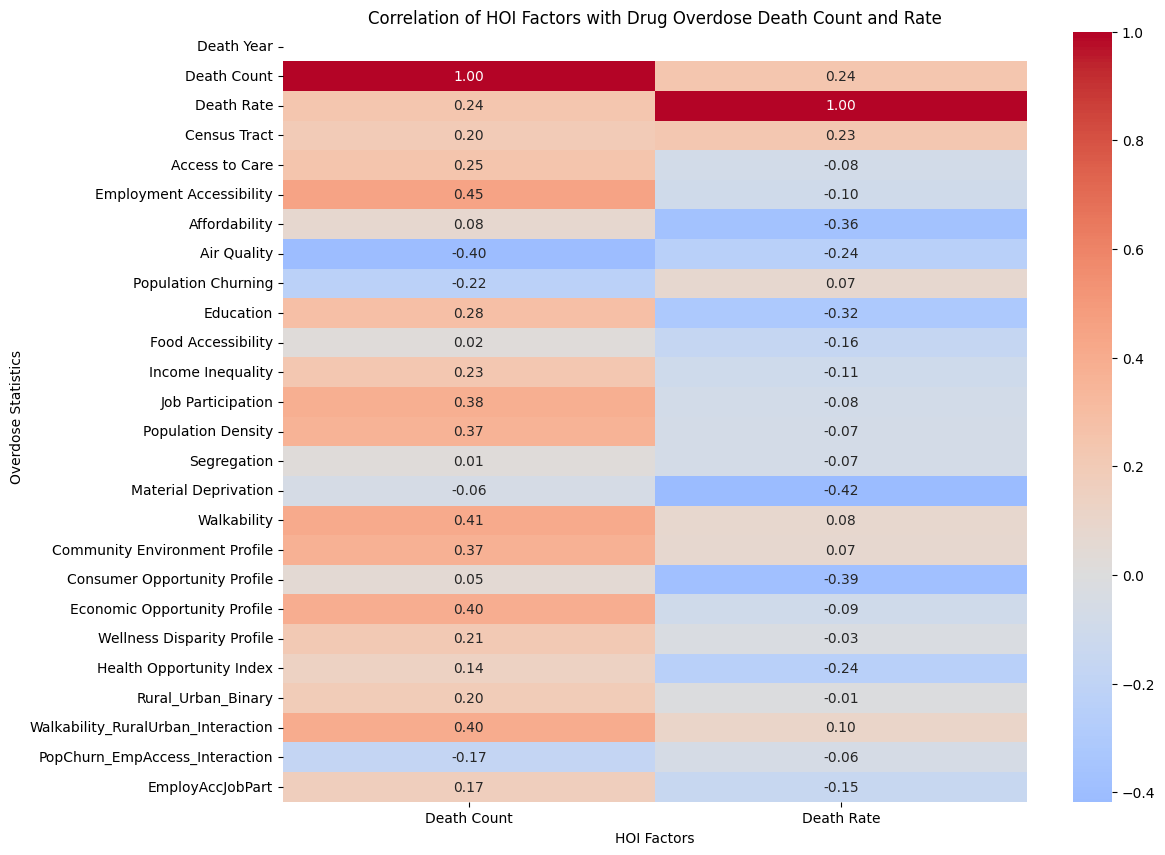

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_overdose, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation of HOI Factors with Drug Overdose Death Count and Rate')
plt.xlabel('HOI Factors')
plt.ylabel('Overdose Statistics')
plt.show()

In [ ]:
urban_rural_impact = combined_df.groupby('Rural_Urban_Binary')[['Death Count', 'Death Rate']].mean().reset_index()

print(urban_rural_impact)


   Rural_Urban_Binary  Death Count  Death Rate
0                   0     8.969697   36.418182
1                   1    23.260000   35.820000


regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = combined_df.drop(columns=['Death Year', 'Census Tract', 'VA FIPS', 'Locality Name', 'Drug Class Legend', 'Death Count', 'Death Rate', 'Access to Care', 'Employment Accessibility', 'Population Churning', 'Income Inequality', 'Job Participation', 'Population Density', 'Segregation', 'Walkability', 'Community Environment Profile', 'Economic Opportunity Profile', 'Wellness Disparity Profile', 'Rural_Urban_Binary'])
y = combined_df['Death Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

print('Intercept:', model.intercept_)
print('Coefficients:')
for feature, coef in zip(X.columns, model.coef_):
    print(f'{feature}: {coef}')

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison_df)

Mean Squared Error (MSE): 321.7666632433611
R-squared (R2): 0.20667106595721452
Intercept: 37.86444359984806
Coefficients:
Affordability: -2.1038647978280283
Air Quality: -7.581659833645986
Education: -13.296301204189172
Food Accessibility: -2.4374780428523417
Material Deprivation: -1.0585303996965332
Consumer Opportunity Profile: 3.6031221727668763
Health Opportunity Index: 0.9961883151555224
Walkability_RuralUrban_Interaction: 5.041342389278292
PopChurn_EmpAccess_Interaction: 1.1139044593644385
EmployAccJobPart: -2.76117929768015
     Actual  Predicted
51     12.9  37.227907
69     39.8  29.078761
31     21.9  27.279872
42     38.9  38.465187
117    40.2  35.721446
77      8.8  33.846394
127    11.9  42.993155
56     34.2  22.112060
40     50.5  44.296098
12     49.9  36.668902
81     20.5  30.288032
26     34.9  48.812262
108    63.5  42.028060
100    87.2  54.546959
66     41.8  43.440929
83     11.3  41.905478
4      37.9  46.295270
27     64.0  42.192103
19     59.2  42.853523
12

Clustering:

For the sake of clustering, we will utlize a K-Means Clustering algorithm.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

file_path = 'VDH-PUD-Overdose_Deaths_By-FIPS_20231106.csv'
data = pd.read_csv(file_path)

print(data.isnull().sum())

numerical_features = ['Death Count', 'Death Rate']
scaler = StandardScaler()

pipeline = Pipeline(steps=[('scaler', scaler)])

scaled_features = pipeline.fit_transform(data[numerical_features])

scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_features)

print(scaled_features_df.head())


Death Year           0
VA FIPS              0
Locality Name        0
Drug Class Legend    0
Death Count          0
Death Rate           0
dtype: int64
   Death Count  Death Rate
0    -0.425979   -0.635470
1    -0.245893   -0.902094
2    -0.471001   -0.227373
3    -0.561044   -0.885770
4    -0.561044   -1.130629


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

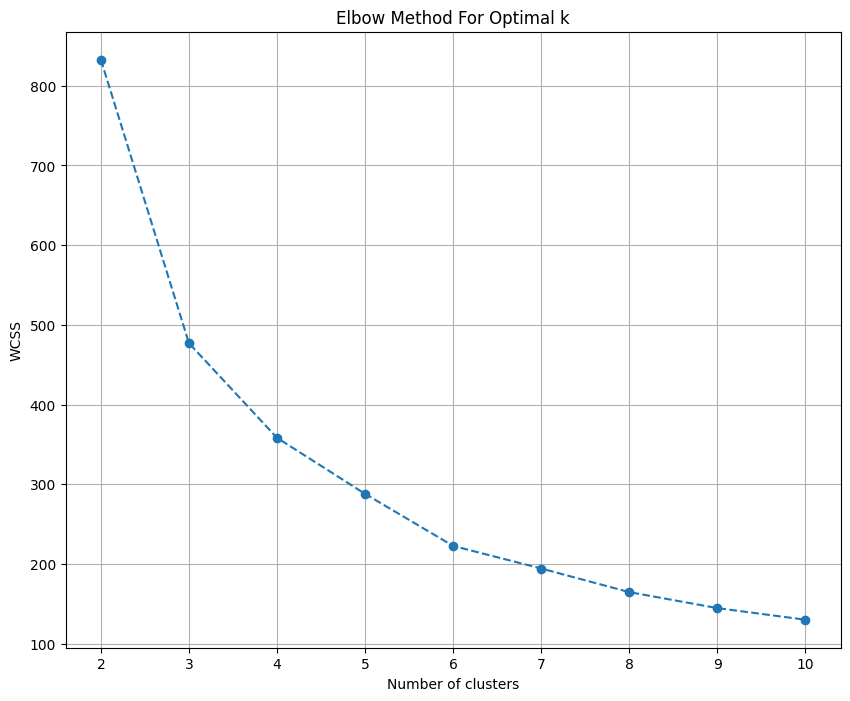

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def calculate_wcss(data):
    wcss = []
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

wcss = calculate_wcss(scaled_features)


plt.figure(figsize=(10, 8))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


We ran a quick elbow method to see if we could determine the optimal number of clusters that we would have to utilize.

We can observe from the graph that the "elbow" exists between 2-3 clusters as that is where the slope of the graph changes the most. Therefore, we will proceed by plotting 3 clusters.

In [ ]:
import pandas as pd

overdose_deaths_path = 'VDH-PUD-Overdose_Deaths_By-FIPS_20231106.csv'
overdose_deaths_data = pd.read_csv(overdose_deaths_path)

overdose_deaths_data.head()


,Death Year,VA FIPS,Locality Name,Drug Class Legend,Death Count,Death Rate
0,2017,51001,Accomack County,All-drug,4,12.3
1,2017,51003,Albemarle County,All-drug,8,7.4
2,2017,51005,Alleghany County,All-drug,3,19.8
3,2017,51007,Amelia County,All-drug,1,7.7
4,2017,51009,Amherst County,All-drug,1,3.2


In [ ]:
us_county_latlng_path = 'us_county_latlng.csv'
us_county_latlng_data = pd.read_csv(us_county_latlng_path)

us_county_latlng_data.head()


,fips_code,name,lng,lat
0,1059,Franklin,-87.843283,34.442381
1,13111,Fannin,-84.319296,34.864126
2,19109,Kossuth,-94.206898,43.204140
3,40115,Ottawa,-94.810589,36.835878
4,42115,Susquehanna,-75.800905,41.821277


In [ ]:
combined_df['VA FIPS'] = combined_df['VA FIPS'].astype(str)

virginia_latlng_data = us_county_latlng_data[us_county_latlng_data['fips_code'].isin(overdose_deaths_data['VA FIPS'])]
virginia_latlng_data['fips_code'] = virginia_latlng_data['fips_code'].astype(str)

virginia_overdose_geo_data = pd.merge(combined_df, virginia_latlng_data, how='left', left_on='VA FIPS', right_on='fips_code')

virginia_overdose_geo_data.drop(columns=["fips_code", "VA FIPS", "Death Count", "Death Rate", "Locality Name", "name", "Drug Class Legend"], inplace=True)

virginia_overdose_geo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 132
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Death Year                          133 non-null    int64  
 1   Census Tract                        133 non-null    float64
 2   Access to Care                      133 non-null    float64
 3   Employment Accessibility            133 non-null    float64
 4   Affordability                       133 non-null    float64
 5   Air Quality                         133 non-null    float64
 6   Population Churning                 133 non-null    float64
 7   Education                           133 non-null    float64
 8   Food Accessibility                  133 non-null    float64
 9   Income Inequality                   133 non-null    float64
 10  Job Participation                   133 non-null    float64
 11  Population Density                  133 non-n

<ipython-input-39-f0955ab057f0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virginia_latlng_data['fips_code'] = virginia_latlng_data['fips_code'].astype(str)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


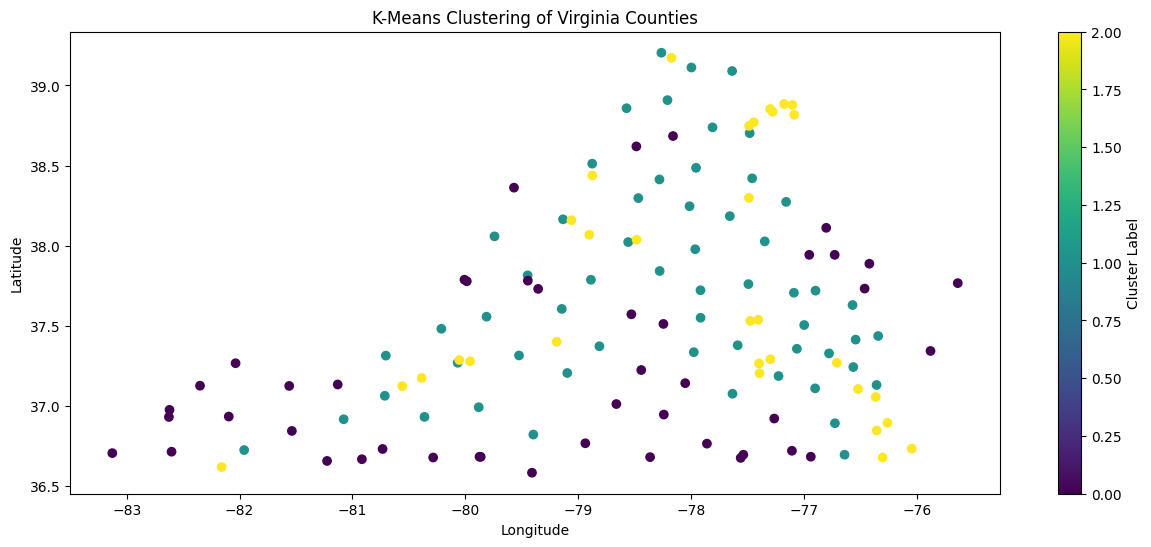

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = virginia_overdose_geo_data.drop(columns=["lng", "lat"])


kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

virginia_overdose_geo_data['cluster'] = kmeans.labels_

plt.figure(figsize=(15, 6))
plt.scatter(virginia_overdose_geo_data['lng'], virginia_overdose_geo_data['lat'], c=virginia_overdose_geo_data['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Virginia Counties')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


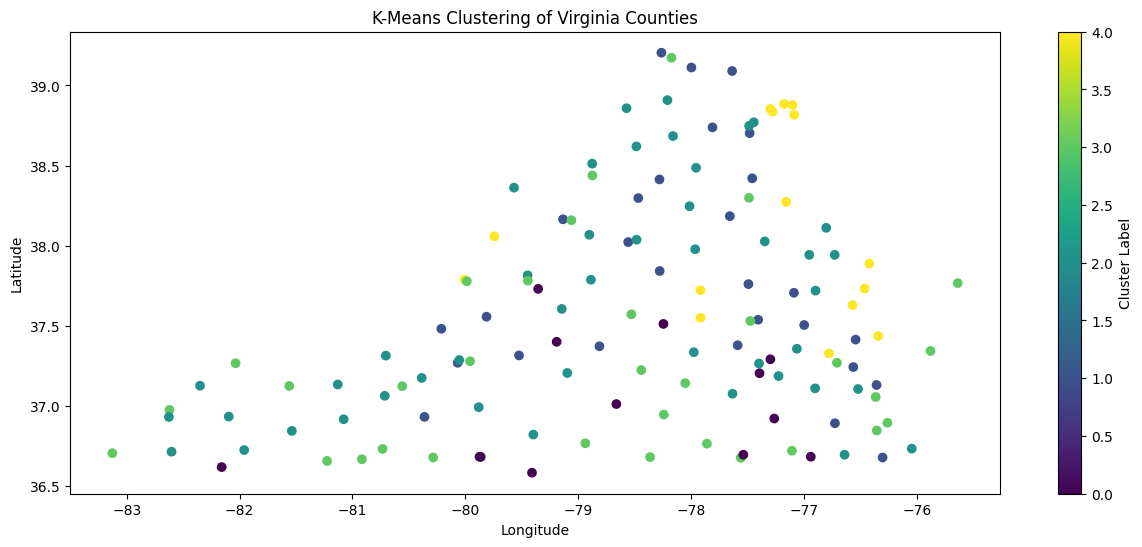

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


Y = virginia_overdose_geo_data[["Consumer Opportunity Profile", "Affordability", "Health Opportunity Index"]]


kmeans = KMeans(n_clusters=5, random_state=42).fit(Y)

virginia_overdose_geo_data['cluster'] = kmeans.labels_

plt.figure(figsize=(15, 6))
plt.scatter(virginia_overdose_geo_data['lng'], virginia_overdose_geo_data['lat'], c=virginia_overdose_geo_data['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Virginia Counties')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()



<ipython-input-42-67c20d50144b>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hoi_county_level = hoi_data.groupby('CountyFIPS').mean().reset_index()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


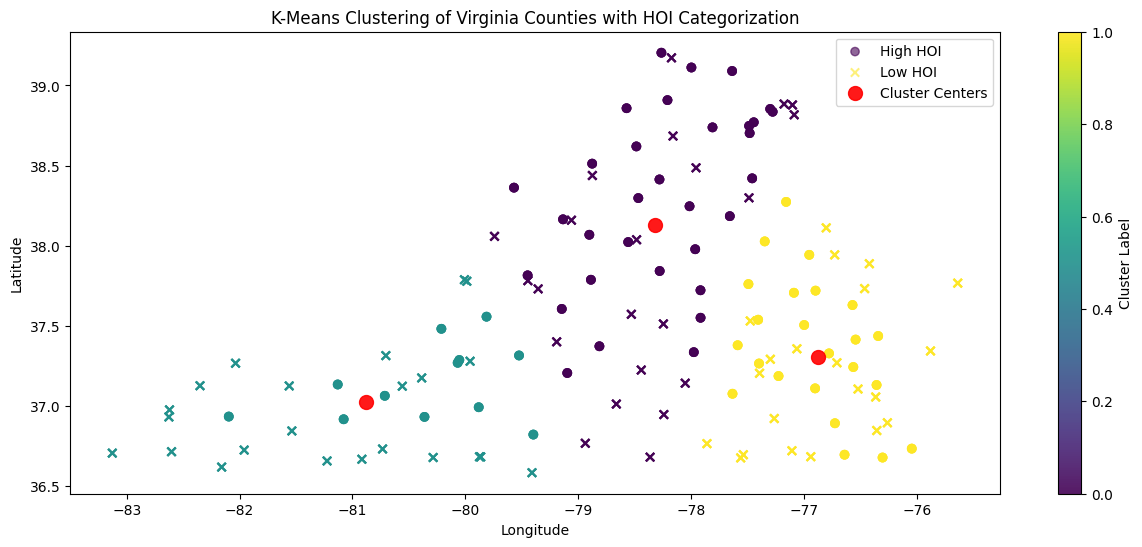

In [ ]:
import pandas as pd

hoi_path = 'Health_Opportunity_Index_20231106.csv'
hoi_data = pd.read_csv(hoi_path)

hoi_data['CountyFIPS'] = hoi_data['Census Tract'].astype(str).str.slice(0, 5).astype(int)

hoi_county_level = hoi_data.groupby('CountyFIPS').mean().reset_index()

merged_data = pd.merge(overdose_deaths_data, hoi_county_level, how='left', left_on='VA FIPS', right_on='CountyFIPS')

merged_data = pd.merge(merged_data, us_county_latlng_data, how='left', left_on='VA FIPS', right_on='fips_code')

from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0).fit(merged_data[['lat', 'lng']])

merged_data['cluster'] = kmeans.labels_

hoi_median = merged_data['Health Opportunity Index'].median()

merged_data['HOI Category'] = np.where(merged_data['Health Opportunity Index'] >= hoi_median, 'High HOI', 'Low HOI')

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

high_hoi = merged_data[merged_data['HOI Category'] == 'High HOI']
plt.scatter(high_hoi['lng'], high_hoi['lat'], c=high_hoi['cluster'], marker='o', label='High HOI', cmap='viridis', alpha=0.6)

low_hoi = merged_data[merged_data['HOI Category'] == 'Low HOI']
plt.scatter(low_hoi['lng'], low_hoi['lat'], c=low_hoi['cluster'], marker='x', label='Low HOI', cmap='viridis', alpha=0.6)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.9, label='Cluster Centers')

plt.title('K-Means Clustering of Virginia Counties with HOI Categorization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.colorbar(label='Cluster Label')
plt.show()


<ipython-input-43-dd73178da386>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hoi_county_level = hoi_data.groupby('CountyFIPS').mean().reset_index()
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pearson correlation coefficient between 'Employment Accessibility' and 'Death Count': 0.45154665192917076


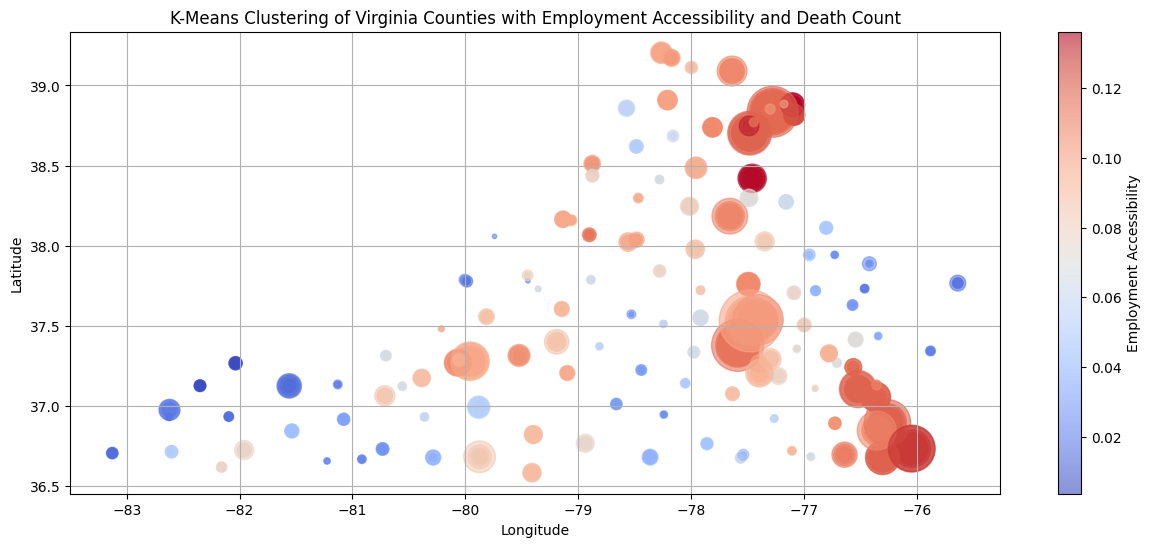

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

overdose_deaths_data = pd.read_csv(overdose_deaths_path)
us_county_latlng_data = pd.read_csv(us_county_latlng_path)
hoi_data = pd.read_csv(hoi_path)
hoi_data['CountyFIPS'] = hoi_data['Census Tract'].astype(str).str.slice(0, 5).astype(int)
hoi_county_level = hoi_data.groupby('CountyFIPS').mean().reset_index()
merged_data = pd.merge(overdose_deaths_data, hoi_county_level, how='left', left_on='VA FIPS', right_on='CountyFIPS')
merged_data = pd.merge(merged_data, us_county_latlng_data, how='left', left_on='VA FIPS', right_on='fips_code')

X = merged_data[['lat', 'lng']]

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

merged_data['cluster'] = kmeans.labels_


correlation, _ = pearsonr(merged_data['Employment Accessibility'], merged_data['Death Count'])
print(f"Pearson correlation coefficient between 'Employment Accessibility' and 'Death Count': {correlation}")

plt.figure(figsize=(15, 6))
scatter = plt.scatter(merged_data['lng'], merged_data['lat'],
                      c=merged_data['Employment Accessibility'], cmap='coolwarm',
                      s=merged_data['Death Count']*10,
                      alpha=0.6)
plt.title("K-Means Clustering of Virginia Counties with Employment Accessibility and Death Count")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Employment Accessibility')
plt.grid(True)
plt.show()
